# Election Forecast 2020

To predict the 2020 election outcome, I estimated a few models. I will first explain the data and then the models.

First, my dataset is organized as state-prediction, with one observation per state (length=55, with NAs). I generated this by averaging all polling percentages within each state, using <a href="https://projects.fivethirtyeight.com/2020-election-forecast/">state-level aggregated polling data from 538</a>. I had hoped to weight them similarly to 538, using a pollster score and/or the sample size. I wasn't able to figure this out.

In [11]:
require(readxl)
require(dplyr)
require(tidyr)
require(MASS)
require(car)
require(ggplot2)

Using the 538 data, I subsetted only the state-level data. Then, I moved the Trump and Biden percentages to within the same observation (the poll IDs were in order). I averaged the percentages for each biden and trump, and created a `state averages` dataframe.

In [48]:
polls <- read.csv("./president_polls.csv", header= T) %>% as.data.frame()
polls_states <- subset(polls, state !="NA", candidate_party="DEM"|"REP")
polls_national <- subset(polls, is.na(state), candidate_party="DEM"|"REP")

#RUN ONLY ONCE
polls_states <- do.call("cbind", split(polls_states, rep(c(1,2), length.out=nrow(polls_states))))
state_avgs <- polls_states %>%
  group_by(state = `1.state`) %>%
  summarize(mean_dem_pct = mean(`1.pct`)/100,
            mean_rep_pct = mean(`2.pct`)/100,
            mean_sample = mean(`1.sample_size`))
head(state_avgs)

state,mean_dem_pct,mean_rep_pct,mean_sample
<fct>,<dbl>,<dbl>,<dbl>
Alabama,0.5006500,0.4738500,1340.8333
Alaska,0.4657567,0.4685633,589.5333
Arizona,0.4133295,0.4150514,1219.3526
Arkansas,0.4906263,0.4900842,1049.0000
California,0.3526925,0.4979119,4168.7239
Colorado,0.4540229,0.4517813,1724.2708


This dataframe has an average for the democratic and the republican percentages across all polls. Additionally, an average sample size.

Next, I wanted to include covariates, or just any additional data that could predict the outcome. I thought of a few predictors: `population change`, `voter registration`, and `covid` deaths and cases.

The population change data is from the U.S. Census Bureau, Population Division. It is the cumulative estimates of resident population change from April 2010 -- July 2019. I used the `percentage change` in my models.

I downloaded the voter registration data from <a href="https://worldpopulationreview.com/state-rankings/number-of-registered-voters-by-state">World Population Review</a>, but it's simply from the Census as well. I used the `percent registered` variable in my models. I also utilized that times the average population from 2019 to get an estimate of voters in a state.

Finally, I used covid `deaths` and `cases` by state from the New York Times' github.

In [49]:
populationdata <- read_excel("./statepopulation.xlsx", col_names=T)
populationdata$changepct <- populationdata$changepct/100
state_avgs <- merge(state_avgs, populationdata, by="state", all.x=T)

registrationdata <- read.csv("./state_regvoters.csv", T)
names(registrationdata)[names(registrationdata)=="State"] <- "state"
state_avgs <- merge(state_avgs, registrationdata, by="state", all.x=T)

covid <- read.csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", T)
covid<- aggregate(cbind(covid$cases, covid$deaths), by=list(state=covid$state), FUN=sum)
names(covid)[names(covid)=="V1"] <- "cases"
names(covid)[names(covid)=="V2"] <- "deaths"
state_avgs <- merge(state_avgs, covid, by="state", all.x=T)
state_avgs$cases_scaled <- state_avgs$cases/state_avgs$jul2019est
state_avgs$deaths_scaled <- state_avgs$deaths/state_avgs$jul2019est

head(state_avgs)

,state,mean_dem_pct,mean_rep_pct,mean_sample,apr2010est,jul2019est,changenum,changepct,registeredPerc,totalRegistered,cases,deaths,cases_scaled,deaths_scaled
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,Alabama,0.5006500,0.4738500,1340.8333,4780125,4903185,123060,0.02574410,0.664,2490000,15006382,278541,3.060538,0.056808177
2,Alaska,0.4657567,0.4685633,589.5333,710249,731545,21296,0.02998385,0.644,337000,762804,4787,1.042730,0.006543685
3,Arizona,0.4133295,0.4150514,1219.3526,6392288,7278717,886429,0.13867163,0.608,3262000,23915910,586225,3.285732,0.080539606
4,Arkansas,0.4906263,0.4900842,1049.0000,2916031,3017804,101773,0.03490121,0.558,1262000,7758898,112574,2.571041,0.037303284
5,California,0.3526925,0.4979119,4168.7239,37254519,39512223,2257704,0.06060215,0.519,15690000,83649172,1724167,2.117045,0.043636295
6,Colorado,0.4540229,0.4517813,1724.2708,5029319,5758736,729417,0.14503296,0.608,2645000,8635518,322955,1.499551,0.056080883


**My dependent variables are:**
+ Dichotomous, Biden/Trump win (I generated a variable using the polling averages, below)
+ Continuous, mean Biden votes (generated from multiplying the percent from the averaged polls to the estimated number of voters in the state)

This construction allows me to estimate a logit model as well as a linear model.

**My idependent/predictor variables are:**
+ Covid cases, continuous where a one unit increase is one case (also scaled by 2019 population, with higher numbers indicating more density)
+ Covid deaths, continuous where a one unit increase is one death (also scaled by 2019 population, with higher numbers indicating more density)
+ Change in population, as a percentage: increase/decrease divided by the 2019 population
+ Percent of registered voters, where a one unit increase corresponds to 100% of eligible voters being registered

In [50]:
state_avgs$bidenwin <- ifelse(state_avgs$mean_dem_pct > state_avgs$mean_rep_pct, 1, 0)
state_avgs$trumpwin <- ifelse(state_avgs$mean_dem_pct < state_avgs$mean_rep_pct, 1, 0)

state_avgs$bidenmeanvotes <- (state_avgs$mean_dem_pct) * (state_avgs$jul2019est*state_avgs$registeredPerc)
state_avgs$trumpmeanvotes <- (state_avgs$mean_rep_pct) * (state_avgs$jul2019est*state_avgs$registeredPerc)

head(state_avgs)

,state,mean_dem_pct,mean_rep_pct,mean_sample,apr2010est,jul2019est,changenum,changepct,registeredPerc,totalRegistered,cases,deaths,cases_scaled,deaths_scaled,bidenwin,trumpwin,bidenmeanvotes,trumpmeanvotes
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alabama,0.5006500,0.4738500,1340.8333,4780125,4903185,123060,0.02574410,0.664,2490000,15006382,278541,3.060538,0.056808177,1,0,1629973.6,1542720.5
2,Alaska,0.4657567,0.4685633,589.5333,710249,731545,21296,0.02998385,0.644,337000,762804,4787,1.042730,0.006543685,0,1,219424.9,220747.2
3,Arizona,0.4133295,0.4150514,1219.3526,6392288,7278717,886429,0.13867163,0.608,3262000,23915910,586225,3.285732,0.080539606,0,1,1829173.1,1836793.5
4,Arkansas,0.4906263,0.4900842,1049.0000,2916031,3017804,101773,0.03490121,0.558,1262000,7758898,112574,2.571041,0.037303284,1,0,826182.6,825269.8
5,California,0.3526925,0.4979119,4168.7239,37254519,39512223,2257704,0.06060215,0.519,15690000,83649172,1724167,2.117045,0.043636295,0,1,7232610.7,10210602.4
6,Colorado,0.4540229,0.4517813,1724.2708,5029319,5758736,729417,0.14503296,0.608,2645000,8635518,322955,1.499551,0.056080883,1,0,1589675.7,1581826.9


## Linear Model
This model predicts the mean number of votes Biden will receive, according to state-level polls and estimated registered voters. I regress Biden votes on my predictors.

#### Model 1
\begin{equation*}
y(bidenvotes) = \beta_0 + \beta_1Cases + \beta_2Deaths + \beta_3\frac{popchange}{2019pop} + \beta_4\frac{registered}{eligible} + \epsilon
\end{equation*}

#### Model 2
\begin{equation*}
y(trumpvotes) = \beta_0 + \beta_1Cases + \beta_2Deaths + \beta_3\frac{popchange}{2019pop} + \beta_4\frac{registered}{eligible} + \epsilon
\end{equation*}

In [62]:
# Models

lm1 <- lm(bidenmeanvotes ~ cases + deaths + changepct + registeredPerc, state_avgs)
summary(lm1)

lm2 <- lm(trumpmeanvotes ~ cases + deaths + changepct + registeredPerc, state_avgs)
summary(lm2)



Call:
lm(formula = bidenmeanvotes ~ cases + deaths + changepct + registeredPerc, 
    data = state_avgs)

Residuals:
     Min       1Q   Median       3Q      Max 
-1123960  -363654   -67027   313751  1494403 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.783e+06  1.101e+06  -1.621  0.11211    
cases           9.576e-02  6.981e-03  13.716  < 2e-16 ***
deaths         -4.406e-01  1.423e-01  -3.097  0.00336 ** 
changepct      -1.176e+06  1.759e+06  -0.668  0.50730    
registeredPerc  3.634e+06  1.623e+06   2.240  0.03011 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 554300 on 45 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.8934,	Adjusted R-squared:  0.884 
F-statistic: 94.33 on 4 and 45 DF,  p-value: < 2.2e-16



Call:
lm(formula = trumpmeanvotes ~ cases + deaths + changepct + registeredPerc, 
    data = state_avgs)

Residuals:
     Min       1Q   Median       3Q      Max 
-1821062  -320549  -175436   182093  1904862 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.204e+06  1.307e+06  -0.921 0.361928    
cases           1.133e-01  8.291e-03  13.667  < 2e-16 ***
deaths         -6.981e-01  1.690e-01  -4.132 0.000155 ***
changepct      -2.960e+06  2.089e+06  -1.417 0.163449    
registeredPerc  2.725e+06  1.927e+06   1.414 0.164272    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 658300 on 45 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.8831,	Adjusted R-squared:  0.8727 
F-statistic: 84.99 on 4 and 45 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


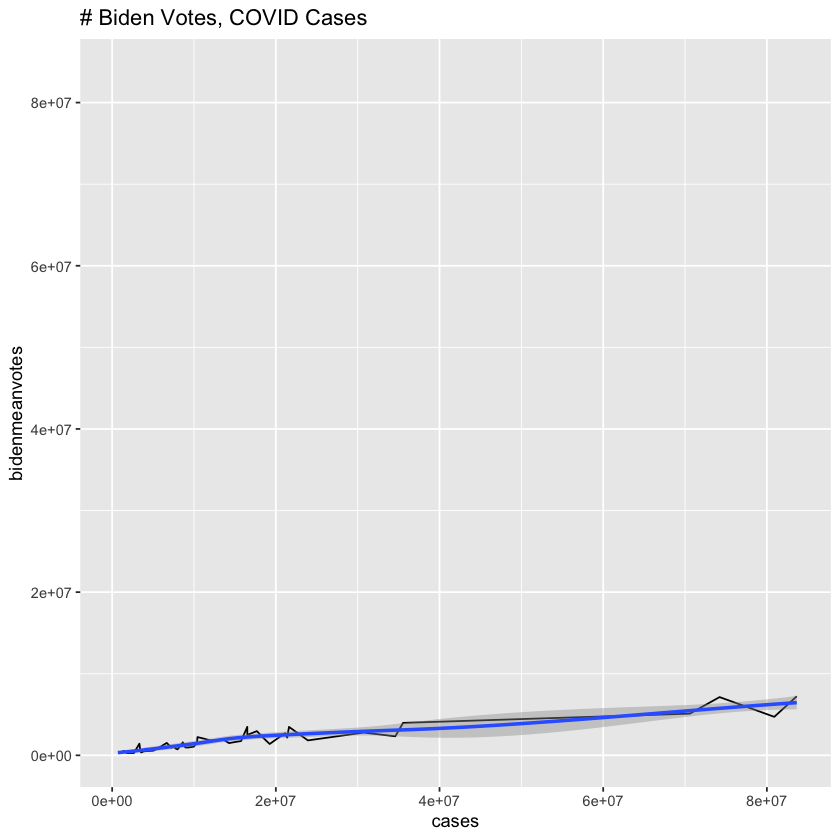

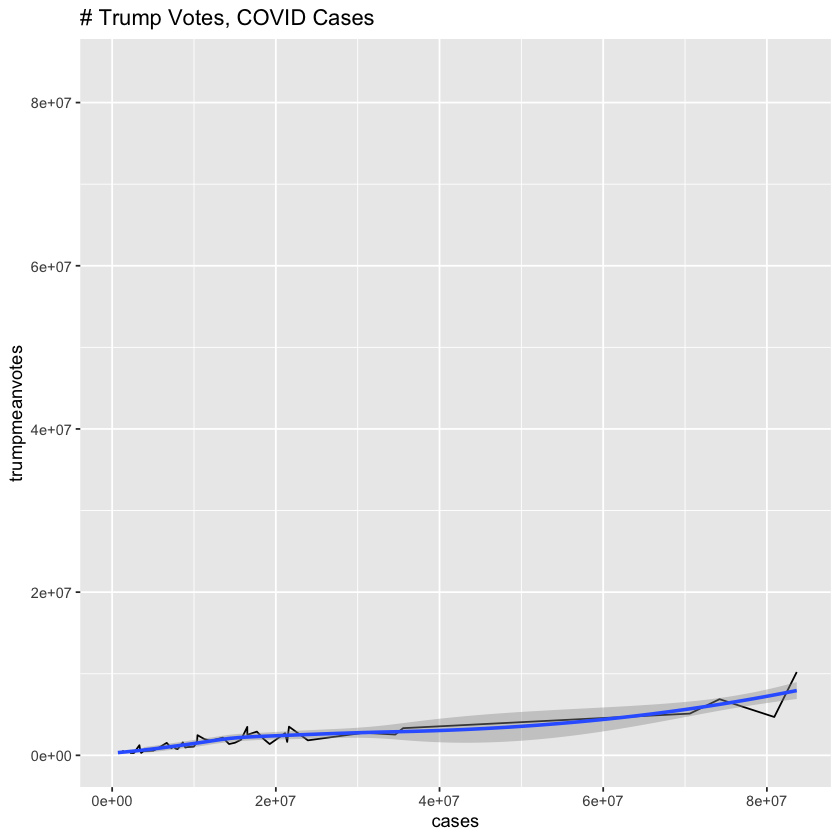

In [63]:
ggplot(lm1, aes(x=cases, y=bidenmeanvotes))+
  geom_line(colour="black", alpha=1) +
  geom_smooth(method="loess") +
  labs(title="# Biden Votes, COVID Cases") +
  ylim(min(state_avgs$cases, na.rm=T),max(state_avgs$cases, na.rm=T))

ggplot(lm2, aes(x=cases, y=trumpmeanvotes))+
  geom_line(colour="black", alpha=1) +
  geom_smooth(method="loess")+
  labs(title="# Trump Votes, COVID Cases") +
  ylim(min(state_avgs$cases, na.rm=T),max(state_avgs$cases, na.rm=T))


Call:
lm(formula = mean_dem_pct ~ cases + deaths + changepct + registeredPerc, 
    data = state_avgs)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.052733 -0.017600 -0.004249  0.018441  0.061166 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5.948e-01  6.098e-02   9.755 1.12e-12 ***
cases          -1.173e-09  3.868e-10  -3.031  0.00403 ** 
deaths          3.741e-09  7.883e-09   0.475  0.63735    
changepct      -7.882e-02  9.748e-02  -0.809  0.42303    
registeredPerc -1.792e-01  8.991e-02  -1.993  0.05235 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03071 on 45 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.2983,	Adjusted R-squared:  0.2359 
F-statistic: 4.783 on 4 and 45 DF,  p-value: 0.002663


`geom_smooth()` using formula 'y ~ x'




Call:
lm(formula = mean_rep_pct ~ cases + deaths + changepct + registeredPerc, 
    data = state_avgs)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.067667 -0.021122 -0.000647  0.018090  0.059593 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5.625e-01  6.226e-02   9.035 1.13e-11 ***
cases          -1.704e-10  3.950e-10  -0.431    0.668    
deaths         -8.127e-09  8.049e-09  -1.010    0.318    
changepct      -1.302e-01  9.954e-02  -1.308    0.197    
registeredPerc -1.460e-01  9.181e-02  -1.590    0.119    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03136 on 45 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.1157,	Adjusted R-squared:  0.03706 
F-statistic: 1.471 on 4 and 45 DF,  p-value: 0.2267


`geom_smooth()` using formula 'y ~ x'



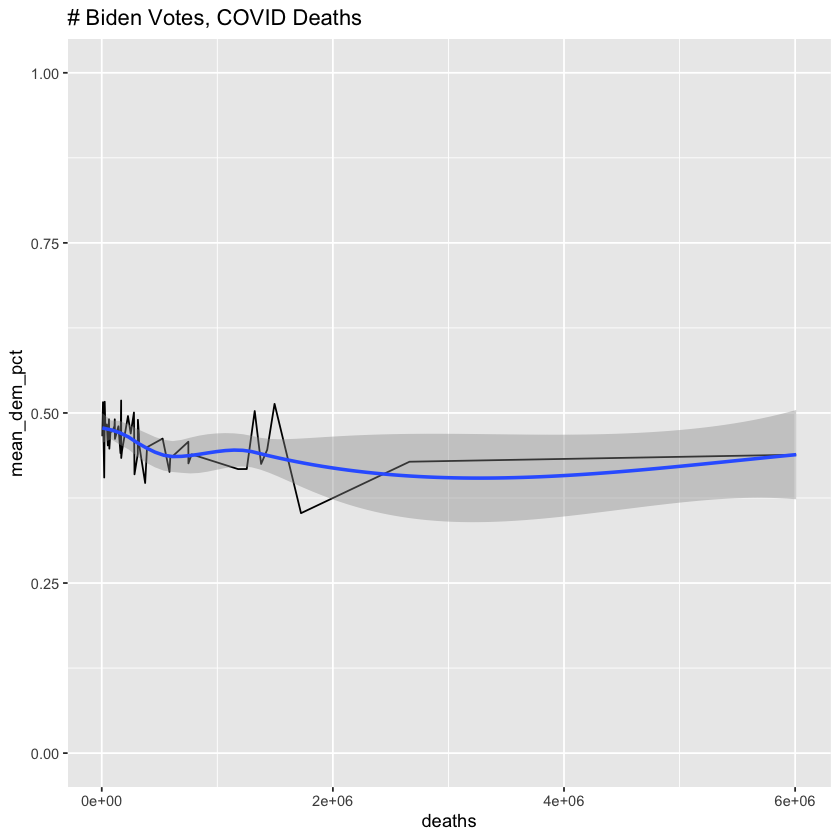

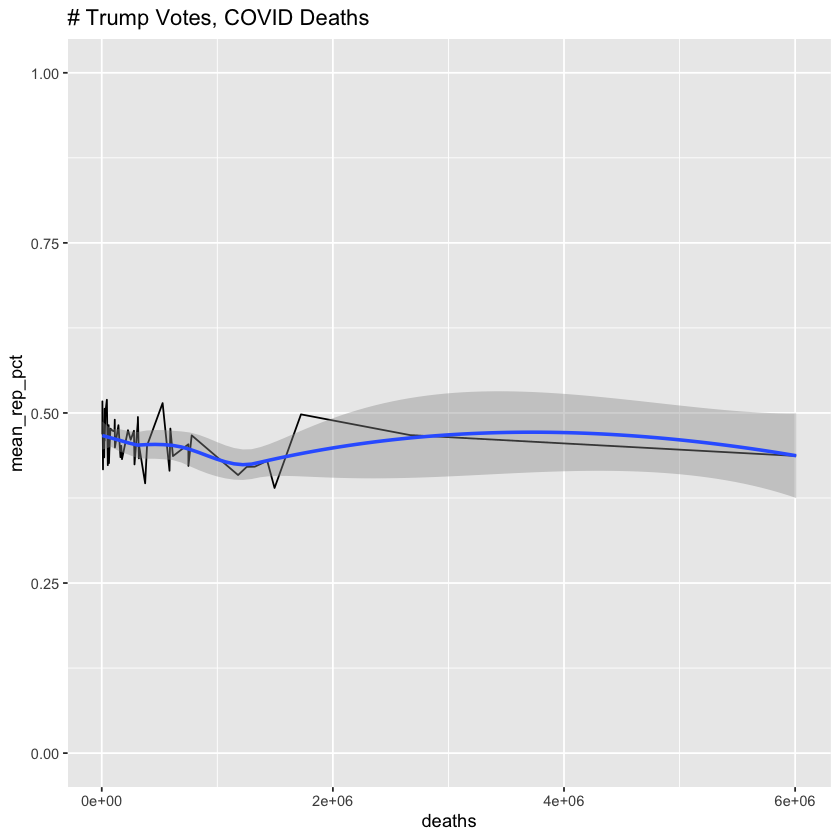

In [82]:
# I also estimate the % of votes, treating it as continuous
lm3 <- lm(mean_dem_pct ~ cases + deaths + changepct + registeredPerc, state_avgs)
summary(lm3)
ggplot(lm3, aes(x=deaths, y=mean_dem_pct))+
  geom_line(colour="black", alpha=1) +
  geom_smooth(method="loess") +
  labs(title="# Biden Votes, COVID Deaths") +
  ylim(0,1)

lm4 <- lm(mean_rep_pct ~ cases + deaths + changepct + registeredPerc, state_avgs)
summary(lm4)
ggplot(lm4, aes(x=deaths, y=mean_rep_pct))+
  geom_line(colour="black", alpha=1) +
  geom_smooth(method="loess") +
  labs(title="# Trump Votes, COVID Deaths") +
  ylim(0,1)

## Logit Model
This model predicts whether Biden will win, i.e. reveive more votes than trump, according to state-level polls.
I present the odds ratios and the log odds, the latter equation is,
\begin{equation*}
ln(\frac{p}{1-p})= \beta_0 + \beta_1Cases + \beta_2Deaths + \beta_3\frac{popchange}{2019pop} + \beta_4\frac{registered}{eligible} + \epsilon
\end{equation*}

Where the coefficients represent the the log odds change with a one unit increase in the independent variables.

In [52]:
m1 <- glm(bidenwin ~ cases + deaths + changepct + registeredPerc, state_avgs, family=binomial("logit"))
summary(m1)

print("Odds ratios")
exp(coef(m1))


Call:
glm(formula = bidenwin ~ cases + deaths + changepct + registeredPerc, 
    family = binomial("logit"), data = state_avgs)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.399  -1.239   1.039   1.122   1.208  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)
(Intercept)    -6.855e-01  3.982e+00  -0.172    0.863
cases          -6.601e-09  2.551e-08  -0.259    0.796
deaths          2.717e-07  5.479e-07   0.496    0.620
changepct       1.635e+00  6.384e+00   0.256    0.798
registeredPerc  1.109e+00  5.873e+00   0.189    0.850

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 68.994  on 49  degrees of freedom
Residual deviance: 68.683  on 45  degrees of freedom
  (5 observations deleted due to missingness)
AIC: 78.683

Number of Fisher Scoring iterations: 4


[1] "Odds ratios"


(Intercept)          cases         deaths      changepct registeredPerc 
     0.5038433      1.0000000      1.0000003      5.1309125      3.0321896

In this model, an increase in cases has a minor, but negative, effect on the odds of Biden winning. Deaths has a minor, but positive, effect; an increase in population increases the liklihood of Biden elected; an increase in registered voters increases the odds of Biden being elected.

For example, if COVID deaths in a state increase by 20,000, Biden's odds of winning increases by 0.5%.
If COVID cases increase by 20,000, Biden's odds of winning decreases by 0.013%.

A 1% increase in the population over the past decade corresponds to a 4.13% increase in Biden's odds of winning.
A 1% increase in registered voters corresponds to a 2.03% increase in Biden's odds of winning.

None of these predictors are significant in this model.

In [75]:
set.seed(88898)

casesv <- seq(from=min(state_avgs$cases, na.rm=T), to=max(state_avgs$cases, na.rm=T), by=83377.64)
deathsv <- seq(from=min(state_avgs$deaths, na.rm=T), to=max(state_avgs$deaths, na.rm=T), by=6004.247)
changepctv <- seq(0,0.999,0.001)
registeredPercv <- seq(0,0.999,0.001)

pred.mvrnorm <- mvrnorm(1000, coef(m1), vcov(m1))
nd <- cbind(1,
            cases=casesv,
            deaths=deathsv,
            changepct=changepctv,
            registeredPerc=registeredPercv)
pred_mean <- pred.mvrnorm %*% t(nd) %>% pnorm() %>% apply(2, mean)

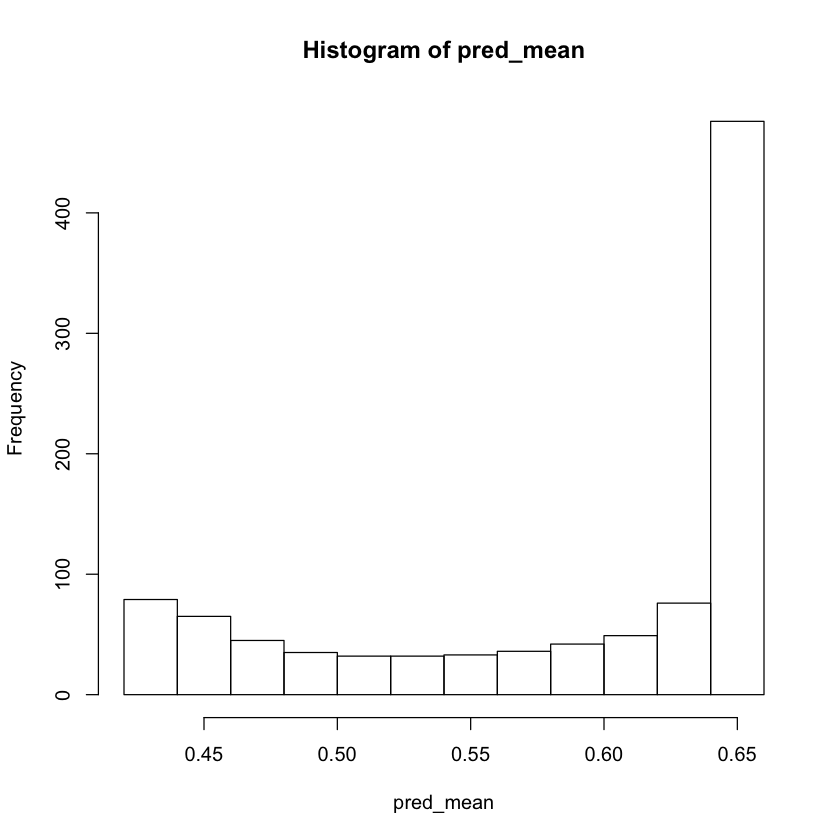

In [76]:
hist(pred_mean)

In 1000 draws, we should expect Biden to win most often.
Additionally, we can look at the number of predictions over 50.1%:

In [77]:
print("Number of predictions over 50.1%, out of 1000")
pred_mean[pred_mean >0.501] %>% length()

[1] "Number of predictions over 50.1%, out of 1000"


[1] 774

Finally, I tried to produce a graph but I think I failed..?

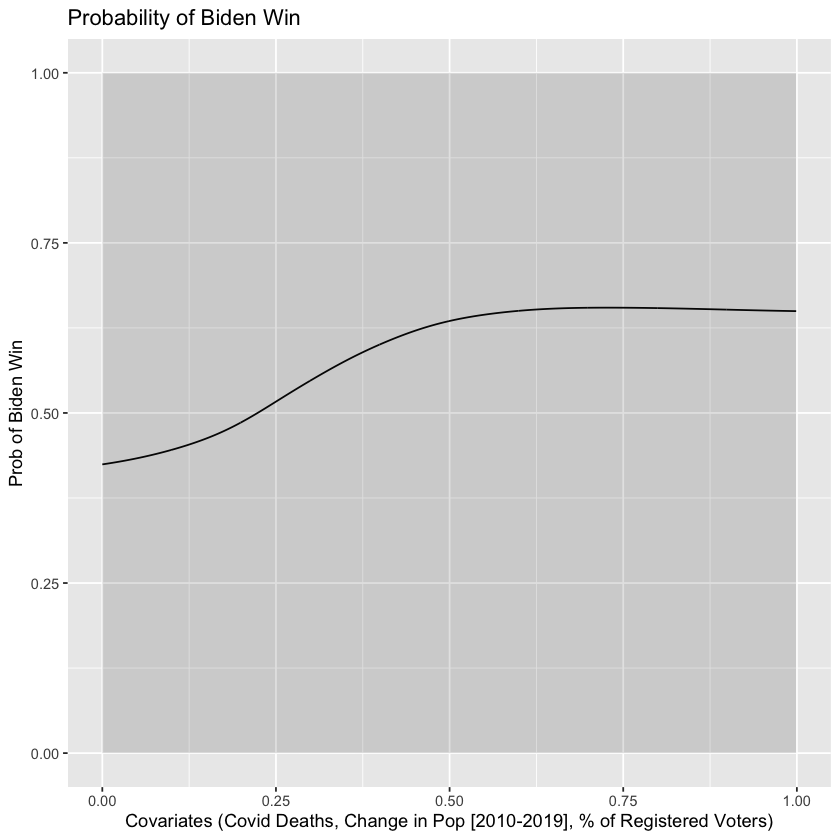

In [81]:
pred_lb <- pred.mvrnorm %*% t(nd) %>% pnorm() %>% apply(2, quantile, 0.025)
pred_ub <- pred.mvrnorm %*% t(nd) %>% pnorm() %>% apply(2, quantile, 0.975)

m1plot <- data.frame(pred_mean, pred_lb, pred_ub, bidenwin=seq(0,0.999,0.001))

ggplot(m1plot, aes(x=bidenwin, y=pred_mean, ymax=pred_ub, ymin=pred_lb))+
  geom_line(colour="black", alpha=1) +
  labs(title="Probability of Biden Win")+
  xlab("Covariates (Covid Deaths, Change in Pop [2010-2019], % of Registered Voters)")+
  ylab("Prob of Biden Win") +
  geom_ribbon(alpha=0.15)

### Thank you! 